In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('legend', fontsize=16)
matplotlib.rcParams['savefig.dpi'] = 1200
from utils_empirical import *
from utils_import_data import *
from utils_nonadaptive import *
from matplotlib.colors import ListedColormap

import pickle

%load_ext autoreload
%autoreload 2


In [2]:
out_dir = "../result/flu/"
out_path = out_dir 
save_path = out_dir + "flu_compare_estimator_design.pkl"
color_palette_dict = geval_color_palette()

## Run synthetic nonadaptive experiment and compare various specifications and designs on the flu data

Import flu data

The duration of carryover effects $\ell = 2$, where $\tau_0 + \tau_1 + \tau_2 = - 0.1\bar{Y}$ 


In [3]:
Y = import_MS_FLU_pos_data()
tau_ratio = -0.1
lag = 2
all_taus = (1+lag - np.array(range(lag+1))); all_taus = all_taus/np.sum(all_taus); all_taus = list(np.mean(Y)*tau_ratio * all_taus)
all_taus_null = [0]*(lag+1)
tau_total = np.mean(Y)*tau_ratio
adj_pct=0.02

Generalized least squares estimator of $\tau_0, \cdots, \tau_{\ell}$ based on the following specifcation

\begin{align}
Y_{it} = \alpha_i +  \beta_t + X_i^{\top}  \theta_t + \tau_0 z_{it} + \tau_1 z_{i,t-1} + \cdots + \tau_{\ell} z_{i,t-\ell}  + u_i^{\top} v_t + \varepsilon_{it}
\end{align}

where 

- $\alpha_i$ is the unknown unit fixed effect
- $\beta_t$ is the unknown time fixed effect
- $X_i$ is the observed covariates with the unknown time-varying coefficients $\theta_t$
- $z_{it}$ is the treatment indicator variable
- $\tau_0$ is the average instantaneous effect, and $\tau_j$ is the average $j$-th period lagged effect for $j \geq 1$
- $u_i$ is the unobserved covariates with the unknown time-varying coefficients $v_t$
- $\varepsilon_{it}$ is the residual

Compare the treatment designs $Z_{\mathrm{ff}}$, $Z_{\mathrm{ba}}$, $Z_{\mathrm{ffba}}$, $Z_{\mathrm{opt}}$, $Z_{\mathrm{opt,linear}}$, and $Z_{\mathrm{opt,stratified}}$

In [4]:
T = 7; num_mc=1000; print_epochs = 100; pre_T = 14
all_Ns = [25,30,35,40,45,50];
J = 1; G = 4
result_gls = dict()

for N in all_Ns:
    params = (N, T)
    np.random.seed(123)
    idx_N_list, idx_T_list, shuffle_list = sample_flu_subblocks(Y, N, T, num_mc=num_mc, pre_T=pre_T)
    pre_Ys, all_Ys = get_all_pre_Ys(Y, idx_N_list, idx_T_list, shuffle_list, pre_T)

    out_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, 
                                                                                  adjust_covar=False, return_std=True, method="GLS", adj_pct=adj_pct)


    this_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, J=J, G=G, 
                                                          adjust_covar=True, adjust_covar_only = True, return_std=True, method="GLS", adj_pct=adj_pct)

    out_dict['opt+_'+str(J)+"_"+str(G)] = this_dict['opt+_'+str(J)+"_"+str(G)]

    result_gls[N] = out_dict


100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done

Ordinary least squares estimator of $\tau_0, \cdots, \tau_{\ell}$ based on the following specifcation

\begin{align}
Y_{it} = \alpha_i +  \beta_t + X_i^{\top}  \theta_t + \tau_0 z_{it} + \tau_1 z_{i,t-1} + \cdots + \tau_{\ell} z_{i,t-\ell} + \varepsilon_{it}
\end{align}


In [5]:
result_ols = dict(); 

for N in all_Ns:
    params = (N, T)
    np.random.seed(123)
    idx_N_list, idx_T_list, shuffle_list = sample_flu_subblocks(Y, N, T, num_mc=num_mc, pre_T=pre_T)
    pre_Ys, all_Ys = get_all_pre_Ys(Y, idx_N_list, idx_T_list, shuffle_list, pre_T)

    out_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, adjust_covar=False, 
                                                                                  return_std=True, method="OLS", adj_pct=adj_pct)

    this_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, J=J, G=G, 
                                                          adjust_covar=True, adjust_covar_only = True, return_std=True, method="OLS", adj_pct=adj_pct)
    
    out_dict['opt+_'+str(J)+"_"+str(G)] = this_dict['opt+_'+str(J)+"_"+str(G)]

    result_ols[N] = out_dict


100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done

Ordinary least squares estimator of $\tau_0, \cdots, \tau_{\ell}$ based on the following specifcation

\begin{align}
Y_{it} = \alpha_i + X_i^{\top}  \theta_t + \tau_0 z_{it} + \tau_1 z_{i,t-1} + \cdots + \tau_{\ell} z_{i,t-\ell} + \varepsilon_{it}
\end{align}


In [6]:
result_unit = dict(); 


for N in all_Ns:
    params = (N, T)
    np.random.seed(123)
    idx_N_list, idx_T_list, shuffle_list = sample_flu_subblocks(Y, N, T, num_mc=num_mc, pre_T=pre_T)
    pre_Ys, all_Ys = get_all_pre_Ys(Y, idx_N_list, idx_T_list, shuffle_list, pre_T)



    out_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, 
                                                                                  adjust_covar=False, return_std=True, method="OLS", adj_pct=adj_pct,
                                                                                 unit_effect=True, time_effect=False)


    this_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, J=J, G=G, 
                                                          adjust_covar=True, adjust_covar_only = True, return_std=True, method="OLS", adj_pct=adj_pct,
                                                                                 unit_effect=True, time_effect=False)

    out_dict['opt+_'+str(J)+"_"+str(G)] = this_dict['opt+_'+str(J)+"_"+str(G)]

    result_unit[N] = out_dict


100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done

Ordinary least squares estimator of $\tau_0, \cdots, \tau_{\ell}$ based on the following specifcation

\begin{align}
Y_{it} =  \beta_t + X_i^{\top}  \theta_t + \tau_0 z_{it} + \tau_1 z_{i,t-1} + \cdots + \tau_{\ell} z_{i,t-\ell} + \varepsilon_{it}
\end{align}


In [7]:
result_time = dict(); 


for N in all_Ns:
    params = (N, T)
    np.random.seed(123)
    idx_N_list, idx_T_list, shuffle_list = sample_flu_subblocks(Y, N, T, num_mc=num_mc, pre_T=pre_T)
    pre_Ys, all_Ys = get_all_pre_Ys(Y, idx_N_list, idx_T_list, shuffle_list, pre_T)



    out_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, 
                                                                                  adjust_covar=False, return_std=True, method="OLS", adj_pct=adj_pct,
                                                                                 unit_effect=False, time_effect=True)


    this_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, J=J, G=G, 
                                                          adjust_covar=True, adjust_covar_only = True, return_std=True, method="OLS", adj_pct=adj_pct,
                                                                                 unit_effect=False, time_effect=True)

    out_dict['opt+_'+str(J)+"_"+str(G)] = this_dict['opt+_'+str(J)+"_"+str(G)]

    result_time[N] = out_dict


100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done

Ordinary least squares estimator of $\tau_0, \cdots, \tau_{\ell}$ based on the following specifcation

\begin{align}
Y_{it} = X_i^{\top}  \theta_t + \tau_0 z_{it} + \tau_1 z_{i,t-1} + \cdots + \tau_{\ell} z_{i,t-\ell} + \varepsilon_{it}
\end{align}


In [8]:
result_no = dict();


for N in all_Ns:
    params = (N, T)
    np.random.seed(123)
    idx_N_list, idx_T_list, shuffle_list = sample_flu_subblocks(Y, N, T, num_mc=num_mc, pre_T=pre_T)
    pre_Ys, all_Ys = get_all_pre_Ys(Y, idx_N_list, idx_T_list, shuffle_list, pre_T)



    out_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, 
                                                                                  adjust_covar=False, return_std=True, method="OLS", adj_pct=adj_pct,
                                                                                 unit_effect=False, time_effect=False)


    this_dict, this_total_dict, this_var_dict, this_total_var_dict = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, J=J, G=G, 
                                                          adjust_covar=True, adjust_covar_only = True, return_std=True, method="OLS", adj_pct=adj_pct,
                                                                                 unit_effect=False, time_effect=False)

    out_dict['opt+_'+str(J)+"_"+str(G)] = this_dict['opt+_'+str(J)+"_"+str(G)]

    result_no[N] = out_dict


100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done
200/1000 done
300/1000 done
400/1000 done
500/1000 done
600/1000 done
700/1000 done
800/1000 done
900/1000 done
1000/1000 done
100/1000 done

In [9]:
summary = dict()
summary['GLS'] = result_gls
summary['OLS'] = result_ols
summary['unit'] = result_unit
summary['time'] = result_time
summary['no'] = result_no

assum_dict = {'GLS': '$\mathrm{two}$-$\mathrm{way}\,\mathrm{fe}$+$\mathrm{covar}$', 'OLS': '$\mathrm{two}$-$\mathrm{way}\,\mathrm{fe}$',
             'unit': '$\mathrm{unit}\,\mathrm{fe}\,\mathrm{only}$', 'time': '$\mathrm{time}\,\mathrm{fe}\,\mathrm{only}$',
             'no': '$\mathrm{no}\,\mathrm{fe}$'}

In [10]:
save_path = out_dir + "flu_mse_estimator_design.pkl"
with open(save_path, 'wb') as handle:
    pickle.dump(summary, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Make Figures EC4 and EC5 in the appendix

In [11]:
color_palette = sns.color_palette("coolwarm")
color_palette_dict = dict()

color_palette_dict[assum_dict['no']] = color_palette[0]
color_palette_dict[assum_dict['unit']] = color_palette[1]
color_palette_dict[assum_dict['time']] = color_palette[2]
color_palette_dict[assum_dict['OLS']] = color_palette[3]
color_palette_dict[assum_dict['GLS']] = color_palette[5]

In [12]:
method = "GLS"
assum_dict = {'GLS': '$\mathrm{two}$-$\mathrm{way}\,\mathrm{fe}$+$\mathrm{covar}$', 'OLS': '$\mathrm{two}$-$\mathrm{way}\,\mathrm{fe}$',
             'unit': '$\mathrm{unit}\,\mathrm{fe}\,\mathrm{only}$', 'time': '$\mathrm{time}\,\mathrm{fe}\,\mathrm{only}$',
             'no': '$\mathrm{no}\,\mathrm{fe}$'}

out = dict()
method_col = '$\mathrm{design}$'
assum_col = '$\mathrm{assumption}$'
method_dict = {'ff': '$Z_{\mathrm{ff}}$', 'ba': '$Z_{\mathrm{ba}}$', 'ffba': '$Z_{\mathrm{ffba}}$', 'opt_0': '$Z_{\mathrm{opt,linear}}$', 'opt': '$Z_{\mathrm{opt}}$'}
method_dict['opt+_'+str(J)+'_'+str(G)] = '$Z_{\mathrm{opt,stratified}}$'

out[method_col] = list()
out[assum_col] = list()

for idx in range(lag+1):
    this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
    out[this_val_col] = list()


for name in ['ff', 'ba','ffba', 'opt_0', 'opt',  'opt+_1_4']:
    for assum in ['no', 'unit', 'time', 'OLS', 'GLS']:
        result = summary[assum]
        out[method_col] = out[method_col] + [method_dict[name]] * num_mc
        out[assum_col] = out[assum_col] + [assum_dict[assum]] * num_mc
        for idx in range(lag+1):
            this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
            out[this_val_col] = out[this_val_col] + list((np.array(result[N][name])[:,idx] - all_taus[lag-idx])**2)
        

out_df = pd.DataFrame(out)
total_val_col = '$\sum_{j}(\hat{\\tau}_{j}-\\tau_{j})^2$'
out_df[total_val_col] = 0 
for idx in range(lag+1):
    this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
    out_df[total_val_col] = out_df[total_val_col] + out_df[this_val_col]

out_df.iloc[:,3:] = out_df.iloc[:,3:] * 1e6

out_df_flu_basic = out_df

In [13]:
N = 25; T = 7
method = "GLS"
out = dict()
method_col = '$\mathrm{design}$'
assum_col = '$\mathrm{assumption}$'
method_dict = {'ff': '$Z_{\mathrm{ff}}$', 'ba': '$Z_{\mathrm{ba}}$', 'ffba': '$Z_{\mathrm{ffba}}$', 'opt_0': '$Z_{\mathrm{opt,linear}}$', 'opt': '$Z_{\mathrm{opt}}$'}
method_dict['opt+_'+str(J)+'_'+str(G)] = '$Z_{\mathrm{opt,stratified}}$'

out[method_col] = list()
out[assum_col] = list()

for idx in range(lag+1):
    this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
    out[this_val_col] = list()


for name in ['opt_0', 'opt',  'opt+_1_4']:
    for assum in ['time', 'OLS', 'GLS']:
        result = summary[assum]
        out[method_col] = out[method_col] + [method_dict[name]] * num_mc
        out[assum_col] = out[assum_col] + [assum_dict[assum]] * num_mc
        for idx in range(lag+1):
            this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
            out[this_val_col] = out[this_val_col] + list((np.array(result[N][name])[:,idx] - all_taus[lag-idx])**2)
        

out_df = pd.DataFrame(out)
total_val_col = '$\sum_{j}(\hat{\\tau}_{j}-\\tau_{j})^2$'
out_df[total_val_col] = 0 
for idx in range(lag+1):
    this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
    out_df[total_val_col] = out_df[total_val_col] + out_df[this_val_col]

out_df.iloc[:,3:] = out_df.iloc[:,3:] * 1e6

out_df_flu_additional = out_df

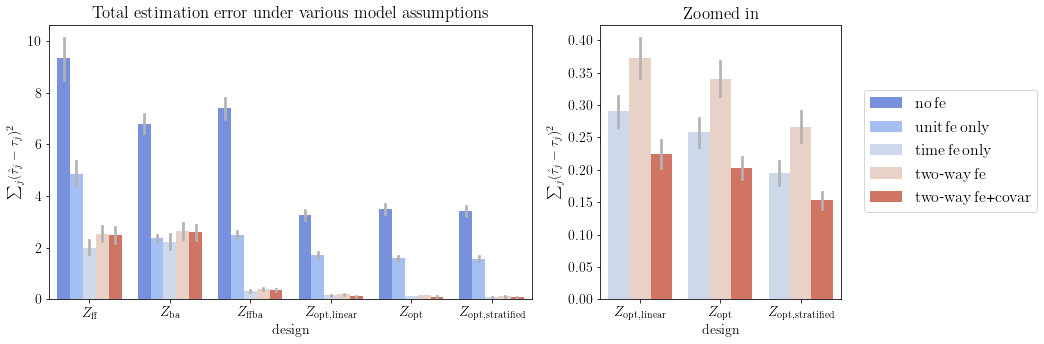

In [14]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5), gridspec_kw={'width_ratios': [2, 1]})
sns.barplot(ax=axes[0],
    data=out_df_flu_basic, 
    x=method_col, y=total_val_col, hue=assum_col,
#     ci="sd", 
    palette=color_palette_dict, errcolor=".7"
)
axes[0].legend('',frameon=False)
axes[0].set_title('$\mathrm{Total\ estimation\ error\ under\ various\ model\ assumptions}$')
# axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.barplot(ax=axes[1],
    data=out_df_flu_additional, 
    x=method_col, y=total_val_col, hue=assum_col,
#     ci="sd", 
    palette=color_palette_dict, errcolor=".7"
)
axes[1].legend('',frameon=False)
axes[1].set_title('$\mathrm{Zoomed\ in}$')

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.0, 0.75))
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
fig.savefig(out_dir+"flu_N_"+str(N)+"_T_"+str(T)+"_various_methods-full.pdf", bbox_inches='tight')

In [15]:
method = "GLS"
out = dict()
N_col = '$N$'
method_col = '$\mathrm{design}$'
assum_col = '$\mathrm{assumption}$'
method_dict = {'ff': '$Z_{\mathrm{ff}}$', 'ba': '$Z_{\mathrm{ba}}$', 'ffba': '$Z_{\mathrm{ffba}}$', 'opt_0': '$Z_{\mathrm{opt,linear}}$', 'opt': '$Z_{\mathrm{opt}}$'}
method_dict['opt+_'+str(J)+'_'+str(G)] = '$Z_{\mathrm{opt,stratified}}$'

out[N_col] = list()
out[method_col] = list()
out[assum_col] = list()

for idx in range(lag+1):
    bias_col = '$bias(\hat{\\tau}_{\mathrm{'+str(idx)+'}})$'
    var_col = '$var(\hat{\\tau}_{\mathrm{'+str(idx)+'}})$'
    out[bias_col] = list()
    out[var_col] = list()


for name in ['ff', 'ba','ffba', 'opt_0', 'opt',  'opt+_1_4']:
    for assum in ['no', 'unit', 'time', 'OLS', 'GLS']:
#     for assum in ['time', 'OLS', 'GLS']:
        result = summary[assum]
        out[N_col] = out[N_col] + [N] *  1
        out[method_col] = out[method_col] + [method_dict[name]] * 1
        out[assum_col] = out[assum_col] + [assum_dict[assum]] * 1
        for idx in range(lag+1):
            bias_col = '$bias(\hat{\\tau}_{\mathrm{'+str(idx)+'}})$'
            out[bias_col] = out[bias_col] + [(np.mean(np.array(result[N][name])[:,idx]) - all_taus[lag-idx])**2]
            var_col = '$var(\hat{\\tau}_{\mathrm{'+str(idx)+'}})$'
            out[var_col] = out[var_col] + [np.mean((np.array(result[N][name])[:,idx] - np.mean(np.array(result[N][name])[:,idx]))**2)]
        

out_df = pd.DataFrame(out)
total_bias_col = '$\sum_{j}\mathrm{bias}(\hat{\\tau}_{j})^2$'
total_var_col = '$\sum_{j}\mathrm{var}(\hat{\\tau}_{j})$'
out_df[total_bias_col] = 0 
out_df[total_var_col] = 0 
for idx in range(lag+1):
    bias_col = '$bias(\hat{\\tau}_{\mathrm{'+str(idx)+'}})$'
    out_df[total_bias_col] = out_df[total_bias_col] + out_df[bias_col]
    var_col = '$var(\hat{\\tau}_{\mathrm{'+str(idx)+'}})$'
    out_df[total_var_col] = out_df[total_var_col] + out_df[var_col]

out_df.iloc[:,3:] = out_df.iloc[:,3:] * 1e6


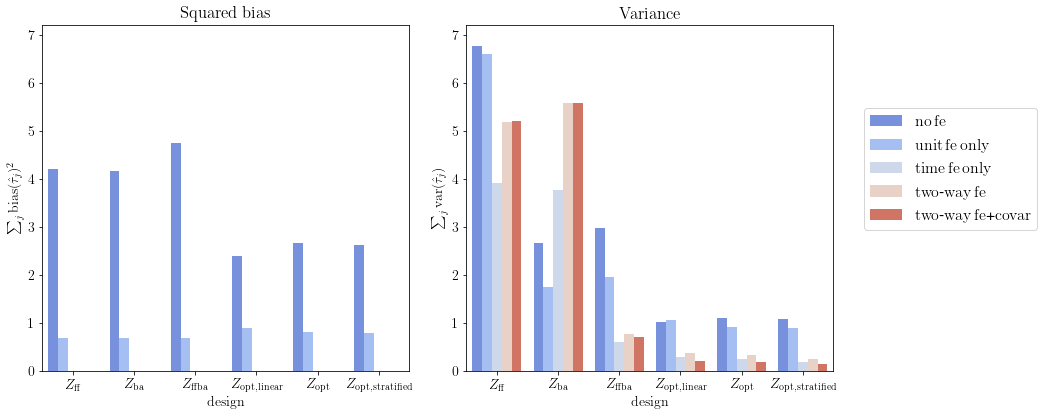

In [16]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6), gridspec_kw={'width_ratios': [1, 1]})
out1 = sns.barplot(ax=axes[0],
    data=out_df, 
    x=method_col, y=total_bias_col, hue=assum_col,
    palette=color_palette_dict, errcolor=".7"
)
out1.set(ylim=[0,7.2])

axes[0].legend('',frameon=False)
axes[0].set_title('$\mathrm{Squared\ bias}$')
out2 = sns.barplot(ax=axes[1],
    data=out_df, 
    x=method_col, y=total_var_col, hue=assum_col,
    palette=color_palette_dict, errcolor=".7"
)
out2.set(ylim=[0,7.2])
axes[1].legend('',frameon=False)
axes[1].set_title('$\mathrm{Variance}$')

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.0, 0.75))
plt.tight_layout()
fig.savefig(out_dir+"flu_N_"+str(N)+"_T_"+str(T)+"_bias-variance.pdf", bbox_inches='tight')